## Group 21

- **Daniil Yefimov**: whole structure of the project: discussion in dataset choice, preprocessing of the data (bringing it to the correct format), descriptive analysis and training settings.
- **Georgi Georgiev**: discussion in dataset choice, training of the model, preprocessing.
- **Praveen Kumar**:
- **Alba Huti**: 

## Project Overview

The primary objective of this project is to employ deep learning techniques to train a Computer Vision model specialized in object detection, such that the model is working effectivelly in urban environment, with a focus on aiding autonomous vehicles in detecting and identifying objects.

For achieving the main task, the following subtasks must be done:

- Choosing dataset, which is suitable for object detection model training in urban environment.
- Description and vizualization of the chosen dataset.
- Preprocessing the dataset in order to improve training of the deep learning model.
- Choosing the deep leagning approach for the model training.
- Compare results of the trained model with reference benchmark.
- Visualize you result on the video/gif.

## Set up

Before moving to the main part, we need to execute the following steps:

#### 1. Install dependencies: python packages

In [ ]:
!pip install -r requirements.txt

#### 2. Import all python packages/functions

In [3]:
import os
import json
import os
import shutil
from ultralytics import YOLO
from ultralytics.data.converter import convert_coco
import torch
import matplotlib.pyplot as plt
import cv2
import fiftyone
from IPython.display import Image

## Dataset

#### 1. Description

Our Group decided to take COCO dataset (Common Objects in Context), which is widely known in Computer Vision community and often used as benchmark for computer vision models. It is comprised of a large collection of images that depict complex scenes with multiple objects in various contexts. The COCO dataset is particularly notable for its diversity, containing images captured in everyday settings such as streets, parks, and outdoor environments. This is perfectly suitable for our main goal: detecting objects in urban environment.

**COCO dataset version:**

- We will use the 2017 version.

**COCO dataset image list structure:**
- id – A unique identifier for the image. The id field maps to the id field in the annotations array (where bounding box information is stored).
- license – Maps to the license array.
- coco_url – The location of the image.
- flickr_url – The location of the image on Flickr.
- width – the width of the image.
- height – The height of the image.
- file_name – The image file name. In this example, file_name and id match, but this is not a requirement for COCO datasets.
- date_captured – the date and time the image was captured.

For our purpose we will need only id, width, height, file_name

**COCO dataset structure of the labels:**
- id – The identifier for the annotation.
- image_id – Corresponds to the image id in the images array.
- category_id – The identifier for the label that identifies the object within a bounding box. It maps to the id field of the categories array.
- iscrowd – Specifies if the image contains a crowd of objects.
- segmentation – Segmentation information for objects on an image. Amazon Rekognition Custom Labels doesn't support segmentation.
- area – The area of the annotation.
- bbox – Contains the coordinates, in pixels, of a bounding box around an object on the image.

For our purposes we will need only image_id, category_id and bbox

**COCO dataset category list structure:**
- upercategory – The parent category for a label.
- id – The label identifier. The id field maps to the category_id field in an annotation object.
- name – the label name.

For our purposes we need only id and name.

**Dataset classes:**

Dataset itself is quite big and it has 80 categories, but we don't need them all for our task. We decided to use only images, which could be useful for urban object detection, hence we downloaded only images, which contain the following objects:
 - person
 - bicycle
 - car
 - motorcycle
 - airplane
 - bus
 - train
 - truck
 - boat
 - traffic light
 - fire hydrant
 - stop sign
 - parking meter
 - bench
 - bird
 - cat
 - dog
 - horse



#### 2. Load data

We will use **fiftyone** library (https://docs.voxel51.com/user_guide/index.html) for download of the COCO dataset, which is a recommended way by COCO dataset maintainers. We will download **train** and **validation** splits, which contains 84k and 3.5k images respectively.

After the execution of the function, the folder structre has the following hierarchy:

- dataset
    - raw
        - json_file_1.json
        - json_file_2.json
    - train
        - data
            - image01_train.jpg
            - image02_train.jpg
            - ...
        - labels.json
    - validation
        - data
            - image01_val.jpg
            - image02_val.jpg
            - ...
        - labels.json


where **labels.json** files contains information about labels of the images. For out purposes we need only **train** and **validation** folders and we can neglect **raw** folder.


In [ ]:
categories = ["person","bicycle","car","motorcycle", "airplane","bus","train","truck","boat","traffic light","fire hydrant","stop sign","parking meter","bench","bird","cat","dog","horse"]


# Load Training dataset
dataset = fiftyone.zoo.load_zoo_dataset(
    "coco-2017",
    splits=["train",'validation'],
    label_types="detections",
    only_matching=True,
    classes=categories,
    dataset_dir = './dataset'
    )


#### 3. Bring Data into YOLO format:

Before this step our data are in COCO format (see description above). In order to use the YOLO deep learning algorithm (will be discussed in the next section), we need to bring it into the correct YOLO format, which has the followinhg structure:

- one *.txt file per image.
- The *.txt file should be formatted with one row per object in [class x_center y_center width height] format (COCO format has [x_min, y_min, width, height] format )
- Box coordinates must be in normalized xywh format (from 0 to 1).
- Class numbers should be zero-indexed (COCO start with 1).

For this transformation we will use **convert_coco** function from ultralytics (maintainers of YOLO).

After this transformation the folder structrue has the following hierarchy:

- dataset
    - raw
        - json_file_1.json
        - json_file_2.json
    - train
        - images
            - image01_train.jpg
            - image02_train.jpg
            - ...
        - labels
            - image01_label.txt
            - image02_label.txt
            - ...
    - validation
        - data
            - image01_val.jpg
            - image02_val.jpg
            - ...
        - labels
            - image01_label.txt
            - image02_label.txt
            - ...


In [ ]:
# Define pathes
input_path = './dataset'


#train yolo format
convert_coco(labels_dir= os.path.join(input_path,'train'),save_dir = './converter_result')
shutil.move('./converter_result/labels/labels', os.path.join(input_path,'train/labels'))
shutil.rmtree('./converter_result')
os.rename(os.path.join(input_path,'train/data'), os.path.join(input_path,'train/images'))


#validation yolo format
convert_coco(labels_dir=os.path.join(input_path,'validation'),save_dir = './converter_result')
shutil.move('./converter_result/labels/labels', os.path.join(input_path,'validation/labels'))
shutil.rmtree('./converter_result')
os.rename(os.path.join(input_path,'validation/data'), os.path.join(input_path,'validation/images'))



In [8]:
# Utilities

# Read Json file
def read_json_file(path):
    f = open(path)
    data = json.load(f)
    f.close()
    return data

# Function to count occurrences of category_id numbers in the list
def count_category_ids(data_list,ids):
    occurrences = {}

    # Iterate over each dictionary in the list
    for data in data_list:
        category_id = data.get('category_id')
        if category_id > 12:
            category_id -= 2
        else:
            category_id -= 1
        # Count occurrences of the category_id
        if category_id in occurrences and category_id in ids:
            occurrences[category_id] += 1
        elif category_id not in occurrences and category_id in ids:
            occurrences[category_id] = 1
        else:
            continue

    return occurrences


def filter_lines(input_file, ids_set):
    with open(input_file, "r") as f:
        lines = f.readlines()
    with open(input_file, "w") as f:
        for line in lines:
            elements = line.strip().split()
            if len(elements) > 0 and int(elements[0]) in ids_set:
                f.write(line)
########################################################################

# Load Json anotation: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
train_labels = read_json_file(os.path.join(input_path,'train/labels.json'))
val_labels = read_json_file(os.path.join(input_path,'validation/labels.json'))

# Category mapping:
categories_mapping = train_labels['categories'][:18]
for item in categories_mapping:
    if item['id'] > 12:
        item['id'] -= 2
    else:
        item['id'] -= 1

# indices of categories, predefined by our group
ids = list(range(18))

# Mapping of the categories
mapping_categories = dict(zip(ids,categories))

# Leave only labels, which are predefined by group
train_labels_path = os.path.join(input_path,'train/labels')
validation_labels_path = os.path.join(input_path,'validation/labels')

for filename in os.listdir(train_labels_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(train_labels_path, filename)
        filter_lines(file_path, ids)


for filename in os.listdir(validation_labels_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(validation_labels_path, filename)
        filter_lines(file_path, ids)


# Count occurrences of category_id in both datasets
train_labels_counts = count_category_ids(train_labels['annotations'],ids)
train_labels_counts = dict(sorted(train_labels_counts.items(), key=lambda x: x[0]))

val_labels_counts = count_category_ids(val_labels['annotations'],ids)
val_labels_counts = dict(sorted(val_labels_counts.items(), key=lambda x: x[0]))

#### 4. Dataset Analysis

**Dataset sizes distribution plot**

In this plot we showed the size of 2 splits:
- Training set
- Test set

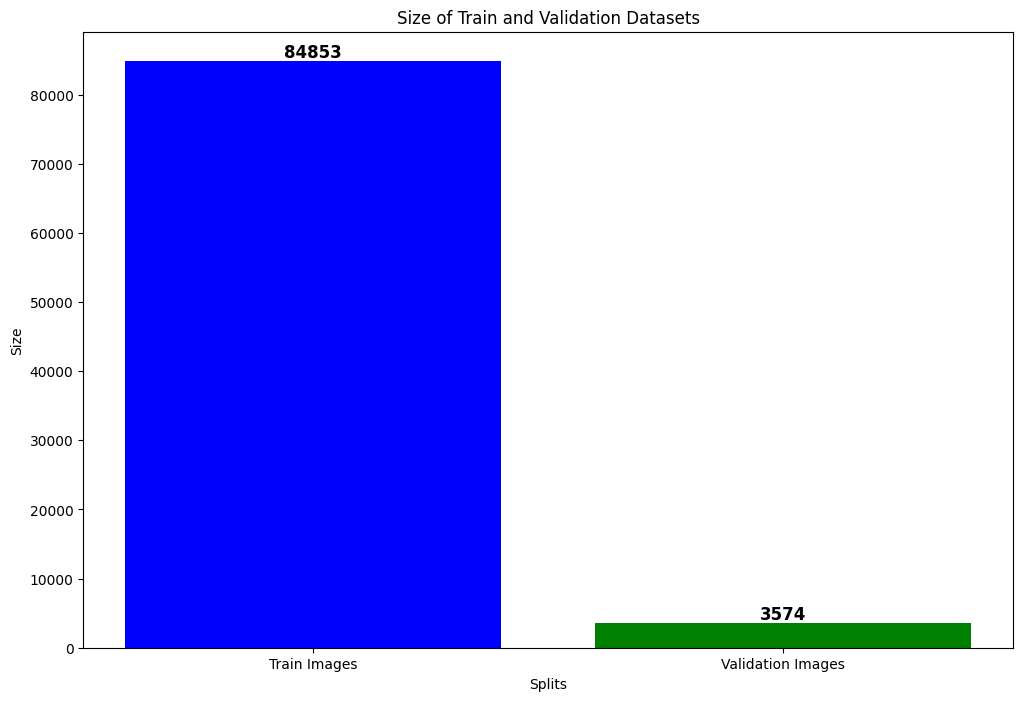

In [ ]:
import os
import matplotlib.pyplot as plt


train_set_size = len(os.listdir(os.path.join(input_path,'train/images')))
val_set_size = len(os.listdir(os.path.join(input_path,'validation/images')))

# Plotting the bar graph
folders = ['Train Images', 'Validation Images']
sizes = [train_set_size, val_set_size]

plt.figure(figsize=(12, 8))
bars = plt.bar(folders, sizes, color=['blue', 'green'])
plt.xlabel('Splits')
plt.ylabel('Size')
plt.title('Size of Train and Validation Datasets')
for bar, size in zip(bars, sizes):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f'{size}',
             ha='center',
             va='bottom',
             fontsize=12,   # Adjust font size
             fontweight='bold')

plt.show()



**Categories Distribution plot**

In this plot we showed the distribution of the predefined (by our group) categories.
As you can observe, the most dominant class in both splits is "person", the rest of the instances are more or less evenly distributed.

Looking at the distribution of both datasets we can visually confirm, that both datasets have similar distribution of the categories. This is important because of the several reasons:

- Generalization: Models trained on data with a distribution that differs significantly from the distribution of the test or validation data may not generalize well to unseen data. If the distributions are similar, the model is more likely to perform consistently across all datasets.

- Fair Evaluation: A model's performance should be evaluated on data that represents the real-world distribution it will encounter in deployment. If the validation data has a different distribution from the training data, the evaluation results may not accurately reflect the model's performance in practical scenarios.

- Bias and Variance: Data with different distributions can introduce bias or variance in model predictions. Models trained on biased datasets may learn to make predictions based on irrelevant features or patterns that are specific to the training data distribution but do not generalize well. Similarly, models trained on datasets with high variance in distribution may struggle to learn meaningful patterns.




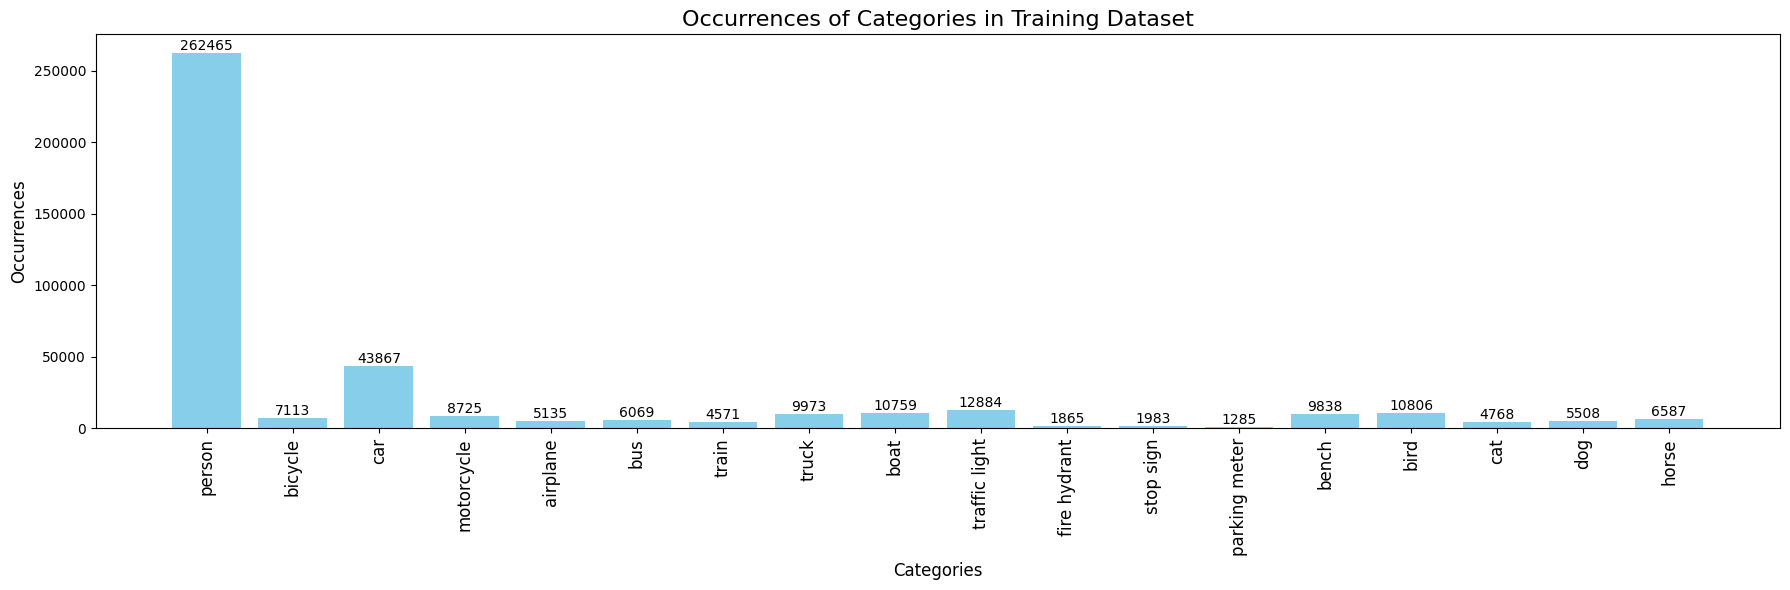

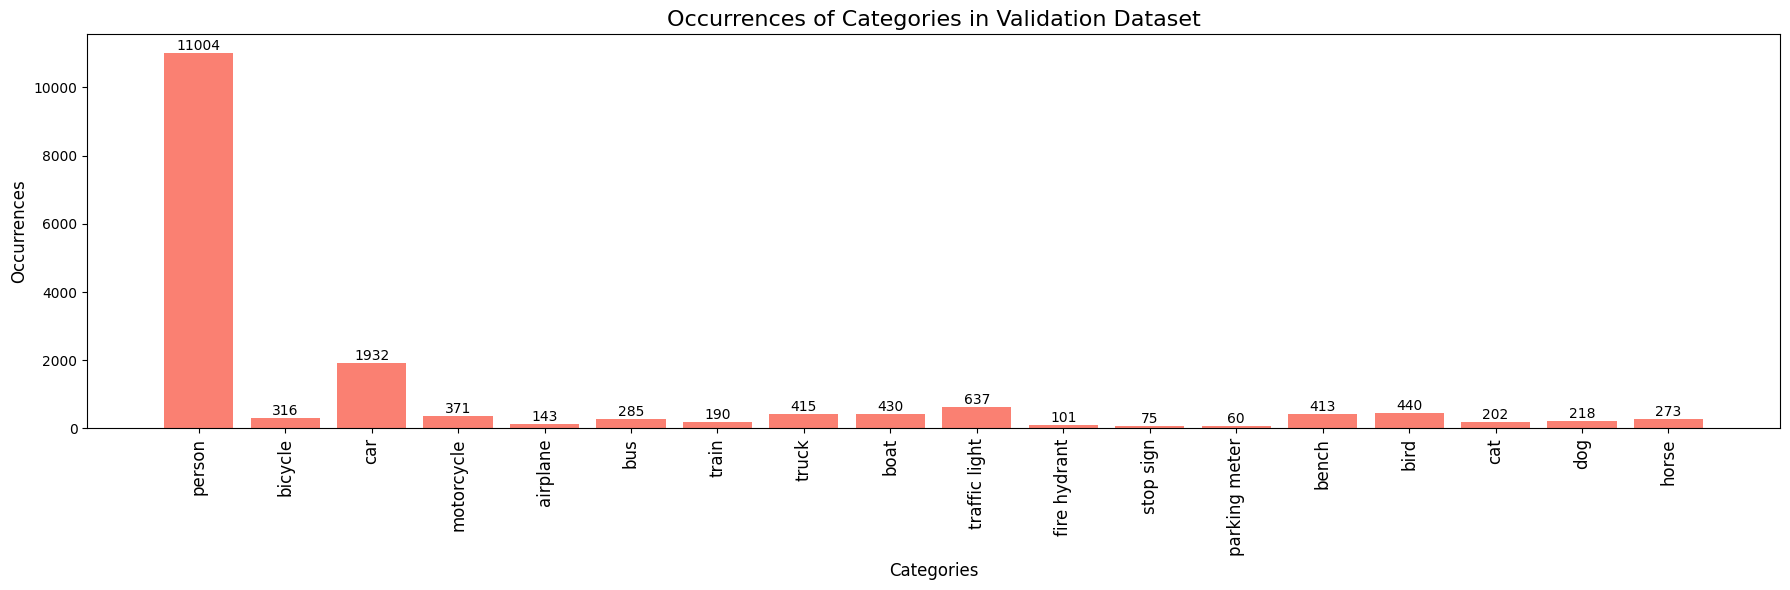

In [ ]:
import matplotlib.pyplot as plt

# Example dictionaries containing category occurrences for training and validation datasets

# Extract category names and occurrences for training data
categories_training = list(train_labels_counts.keys())
training_counts = list(train_labels_counts.values())

# Plot for training data
plt.figure(figsize=(18, 6))
plt.bar(categories_training, training_counts, color='skyblue')
plt.xlabel('Categories',fontsize=12)
plt.ylabel('Occurrences',fontsize=12)
plt.title('Occurrences of Categories in Training Dataset',fontsize=16)
plt.xticks(categories_training, [mapping_categories.get(category, category) for category in categories_training], rotation=90,fontsize=12)

# Annotate bars with counts
for i, count in enumerate(training_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Extract category names and occurrences for validation data

categories_validation = list(train_labels_counts.keys())
validation_counts = list(val_labels_counts.values())

# Plot for validation data
plt.figure(figsize=(18, 6))
plt.bar(categories_validation, validation_counts, color='salmon')
plt.xlabel('Categories',fontsize=12)
plt.ylabel('Occurrences',fontsize=12)
plt.title('Occurrences of Categories in Validation Dataset',fontsize=16)
plt.xticks(categories_validation, [mapping_categories.get(category, category) for category in categories_validation], rotation=90,fontsize=12)

for i, count in enumerate(validation_counts):
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


**Height and width distribution plot**

As we can observe, most of the plots have height and width 640 by 640, but some of them are smaller (height, width or both). We need to bring images size of all image to the same numbers.

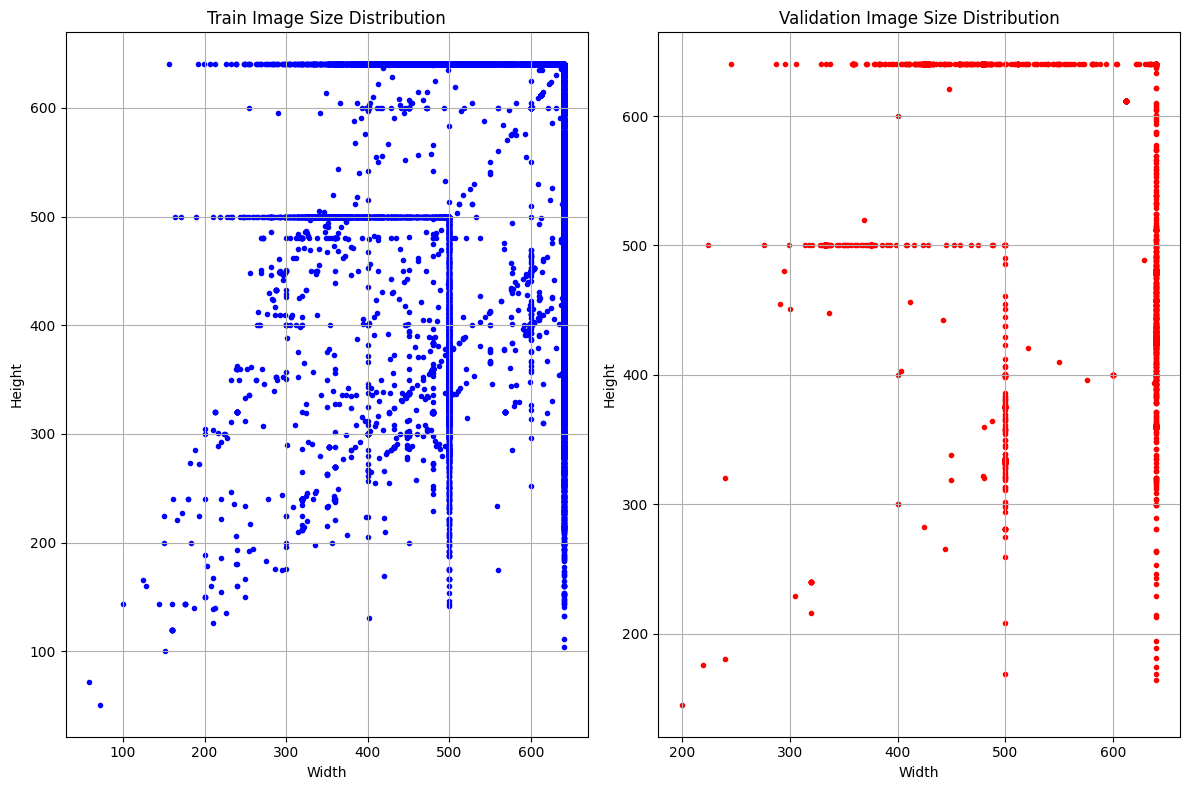

In [ ]:
# Initialize lists to store width and height of each image for train and val labels
train_widths = []
train_heights = []
val_widths = []
val_heights = []

# Iterate over each image in train_labels
for image_info in train_labels['images']:
    width = image_info['width']
    height = image_info['height']
    train_widths.append(width)
    train_heights.append(height)

# Iterate over each image in val_labels
for image_info in val_labels['images']:
    width = image_info['width']
    height = image_info['height']
    val_widths.append(width)
    val_heights.append(height)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

# Plot for train_labels
axs[0].scatter(train_widths, train_heights, color='blue', marker='.')
axs[0].set_title('Train Image Size Distribution')
axs[0].set_xlabel('Width')
axs[0].set_ylabel('Height')
axs[0].grid(True)

# Plot for val_labels
axs[1].scatter(val_widths, val_heights, color='red', marker='.')
axs[1].set_title('Validation Image Size Distribution')
axs[1].set_xlabel('Width')
axs[1].set_ylabel('Height')
axs[1].grid(True)

plt.tight_layout()
plt.show()

**Color Distribution plot**

By analyzing the plot, you can gain insights into the overall color characteristics of the images. For example, we can identify dominant colours, estimate colour balance.

- X-axis: The x-axis represents the range of pixel intensity values from 0 to 255 (staderd RGB). This range covers all possible intensity values for each color channel (red, green, and blue) in an image. Each value on the x-axis corresponds to a particular intensity level.

- Y-axis: The y-axis represents the normalized frequency of occurrence of each pixel intensity value within the range. It indicates how often a particular intensity level appears relative to the total number of pixels in the images. The values are normalized so that the sum of all frequencies equals 1, making it easier to compare distributions across different images.

- Lines: There are three lines in the plot, each representing the mean histogram of pixel intensities for a specific color channel: red, green, and blue. The red line corresponds to the distribution of red pixel intensities, the green line to green pixel intensities, and the blue line to blue pixel intensities.

- Color channels: The color channels represent the contribution of each color to the overall color distribution. For example, if the red line is higher at a certain intensity level, it indicates that there are more pixels with that intensity level in the red channel compared to the other channels.


We can observe, that red and green colour have more pixels with intensity in the middle and in blue colour dominates low intensity pixels.

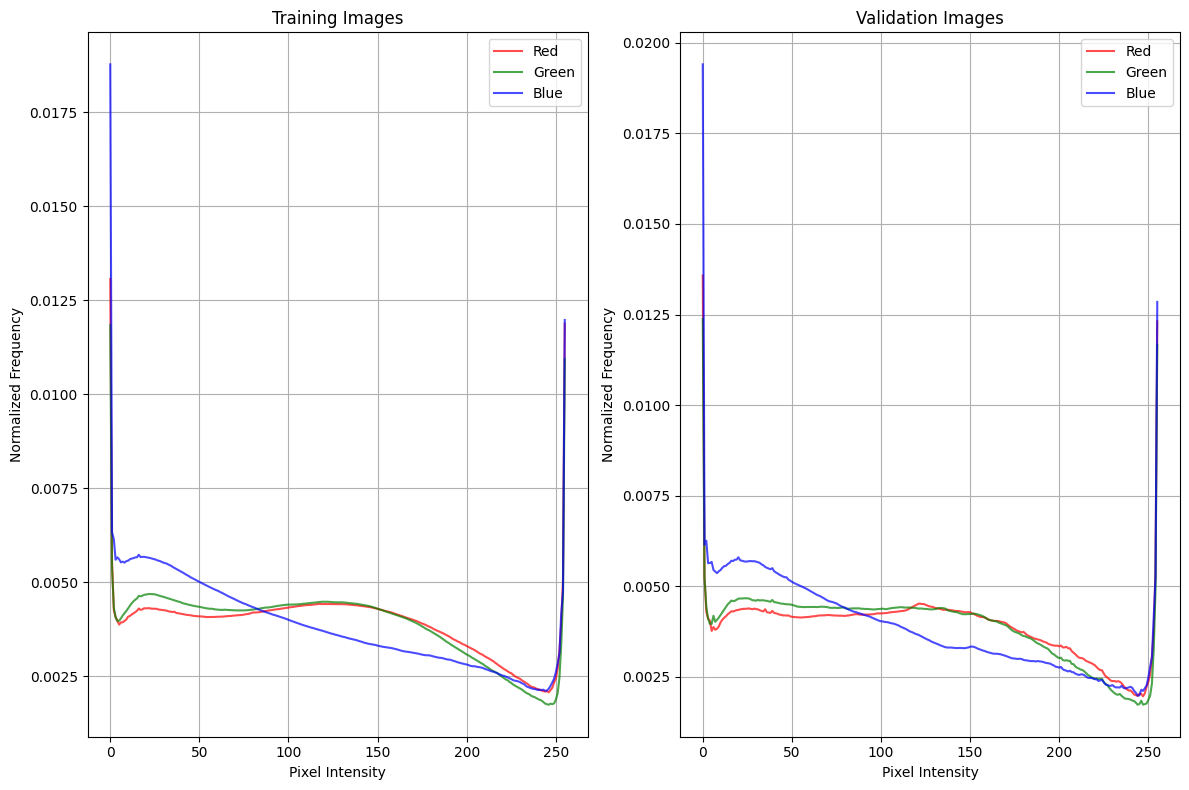

In [ ]:


def plot_color_distribution(image_folder, ax):
    # Initialize lists to store histograms
    red_hist = []
    green_hist = []
    blue_hist = []

    # Iterate over each image file in the directory
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg')):
            # Read the image using OpenCV
            img = cv2.imread(os.path.join(image_folder, filename))
            # Convert BGR image to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Calculate histogram for each color channel
            hist_red = cv2.calcHist([img_rgb], [0], None, [256], [0, 256])
            hist_green = cv2.calcHist([img_rgb], [1], None, [256], [0, 256])
            hist_blue = cv2.calcHist([img_rgb], [2], None, [256], [0, 256])
            # Normalize histograms
            hist_red /= hist_red.sum()
            hist_green /= hist_green.sum()
            hist_blue /= hist_blue.sum()
            # Append histograms to the lists
            red_hist.append(hist_red)
            green_hist.append(hist_green)
            blue_hist.append(hist_blue)

    # Calculate mean histograms
    mean_red_hist = sum(red_hist) / len(red_hist)
    mean_green_hist = sum(green_hist) / len(green_hist)
    mean_blue_hist = sum(blue_hist) / len(blue_hist)

    # Plot color distribution
    ax.plot(mean_red_hist, color='red', label='Red', alpha=0.7)
    ax.plot(mean_green_hist, color='green', label='Green', alpha=0.7)
    ax.plot(mean_blue_hist, color='blue', label='Blue', alpha=0.7)
    ax.set_title('Color Distribution')
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Normalized Frequency')
    ax.legend()
    ax.grid(True)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

# Plot color distribution for training images
train_image_folder = "./dataset/train/images"
plot_color_distribution(train_image_folder, axes[0])
axes[0].set_title('Training Images')

# Plot color distribution for validation images
val_image_folder = "./dataset/validation/images"
plot_color_distribution(val_image_folder, axes[1])
axes[1].set_title('Validation Images')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()



#### 5. Preprocessing


Before we continue with training, couple of preprocessing steps were done:

- In labels we have left only predefined at the beggining categories, in order to concentrate more on the object detection on the road/urban environment. Many of other categories were related to the indoor environment (For example pizza, donut), which would be useless for our task.

- We brought our data from COCO format to YOLO format (described in the step above).

- Pixel values will be normalized: brought from [0,255] range to [0,1] range. This is a standard step for image classification, because it improves convergence of the Neural Network, improves stability of the learning procedure (because of the similar scale) and it helps with preventing overfitting. This will be done by YOLO algorithm implementation.

- Images will be converted to the Pytorch tensors. This will be done by YOLO algorithm implementation.


Additionally, YOLO implementations provided to us many other functionalities for data preprocessing: data augmentation. Data augmentation is useful for several reasons:
- It improves generalization of the model, by helping the models to learn different variations of the same images.
- It helps model to be invariant to different transformations. For example, when the object is rotated model still has the ability to recognize it.

We decided to go with the following settings:
- Altering the saturation of the image by a fraction: we used the value of **0.5** .
- Modifying brightness of the image: we used the value of **0.2**
- Random image rotarion: we choose the value of **10** degrees.
- Scaling image by factor: we choose the value of **0.55**.



## Training

For the Training our group have decided to go with YOLO algorithm:

- It stands for "You Only Look Once".
- It is a single-stage object detector.
- YOLO divides the input image into a grid of cells. Each cell is responsible for predicting bounding boxes and class probabilities for objects whose center falls within the cell.
- For each grid cell, YOLO predicts bounding boxes. Each bounding box is represented by a set of coordinates (x, y, w, h), where (x, y) denotes the center of the box relative to the grid cell, and (w, h) represent the width and height of the box relative to the entire image.
- YOLO predicts probability for each class in bounding box.
- Output format: bouding boxes and each class (with probability).
- YOLO can predicted many bounding boxex for the same object and udring post-processing redundant boxes are eliminated by Non-maximum Suppression algorithm, which selects bounding boxes with highest confidence.


We have decided to go with this algorithm because of 2 reasons:
- High speed of inference, which allows efficient object detection online, which makes it suitable for our main task.
- Several tasks are done in a single neural network,
- YOLO is state of the at object detection algorithm with high accuracy.
- Large open-source commnity, which constantly improves the functionality of the algorithm.



For the training procedure we need to prepare **.yaml** file, where we specify categories and pathes to the labels and images.


#### 1. Reference Experiment



In [10]:
model = YOLO('./model/yolov8n.pt')
metrics = model.val(data='coco.yaml',device = 'cuda:0',imgsz=640,hsv_s = 0.5, hsv_v = 0.2,degrees = 10, scale = 0.55)

Ultralytics YOLOv8.1.29 🚀 Python-3.9.12 torch-2.2.1 CPU (Intel Core(TM) i9-9880H 2.30GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /Users/daniil.yefimov/Desktop/GitHub/Autonomous-Vehicle/dataset/validation/labels.cache... 3574 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3574/3574 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [03:48<00:00,  1.02s/it]


                   all       3574      17230      0.737      0.543      0.622      0.455
                person       3574      10777      0.785      0.656      0.747      0.516
               bicycle       3574        314      0.725      0.369      0.458      0.265
                   car       3574       1918      0.692      0.501      0.563      0.364
            motorcycle       3574        367      0.741      0.561      0.659      0.415
              airplane       3574        143      0.847      0.737      0.835      0.654
                   bus       3574        283      0.768      0.629      0.739      0.621
                 train       3574        190      0.834      0.768      0.836      0.647
                 truck       3574        414       0.58      0.377      0.437      0.295
                  boat       3574        424       0.61      0.278      0.379      0.211
         traffic light       3574        634      0.688      0.334      0.414      0.213
          fire hydran

**Metrics which were used:**
- Box Precision: The accuracy of the detected objects, indicating how many detections were correct.
- Box Recall: The ability of the model to identify all instances of objects in the images.
- mAP50: Mean average precision calculated at an intersection over union (IoU) threshold of 0.50. 
- mAP50-95: the average of the mean average precision calculated at varying IoU thresholds, ranging from 0.50 to 0.95. It gives a comprehensive view of the model's performance across different levels of detection difficulty.

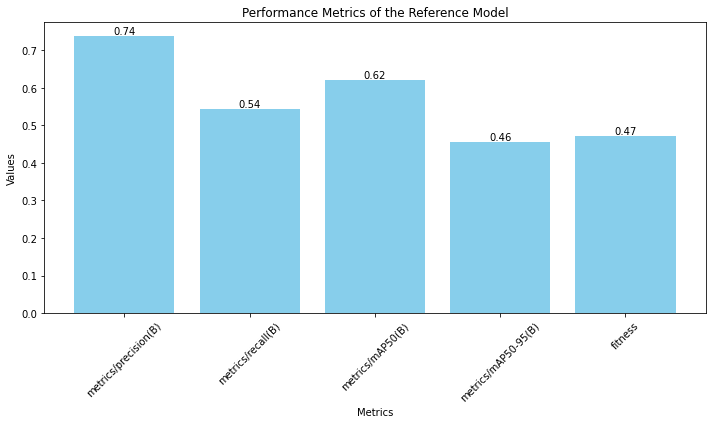

In [11]:
# Extracting metric names and corresponding values
metrics_keys_reference = list(metrics.results_dict.keys())
metrics_values_reference = list(metrics.results_dict.values())

# Creating a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_keys_reference, metrics_values_reference, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics of the Reference Model')
plt.xticks(rotation=45)
for bar, value in zip(bars, metrics_values_reference):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f'{value:.2f}',
             ha='center',
             va='bottom')
plt.tight_layout()

# Displaying the plot
plt.show()


- In pretrained model we can observe quite high Precision Overall (the  ability of correctly predicting identifed objects), but identyfiyng objects itself couble be better (Recall: 0.54), this could be improved by further training of the model.

- many important classes are detected correctly (Person: 0.785, Bicycle: 0.725, Train:0.834). Only Truck class has quite low quality (0.58).
- as mentioned above, Recall could be improve for several classes. Epecially traffice light, truck, bicycle, because not detecting these objects on the road could lead to the crash.
- mAP50-95 and mAP50 confirms statements above. Especially we need to pay attantion to the traffice light, truck.



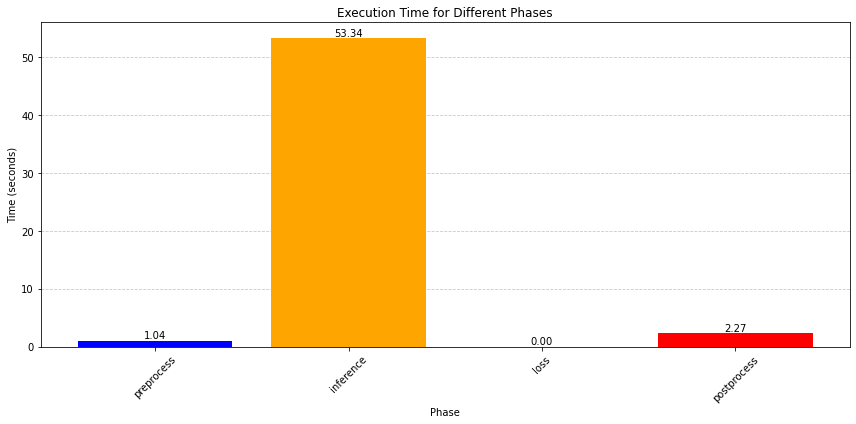

In [12]:


keys_speed = list(metrics.speed.keys())
values_speed = list(metrics.speed.values())

plt.figure(figsize=(12, 6))
plt.bar(keys_speed, values_speed, color=['blue', 'orange', 'green', 'red'])

# Adding the data values on the bars
for i, value in enumerate(values_speed):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

plt.title('Execution Time for Different Phases')
plt.xlabel('Phase')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

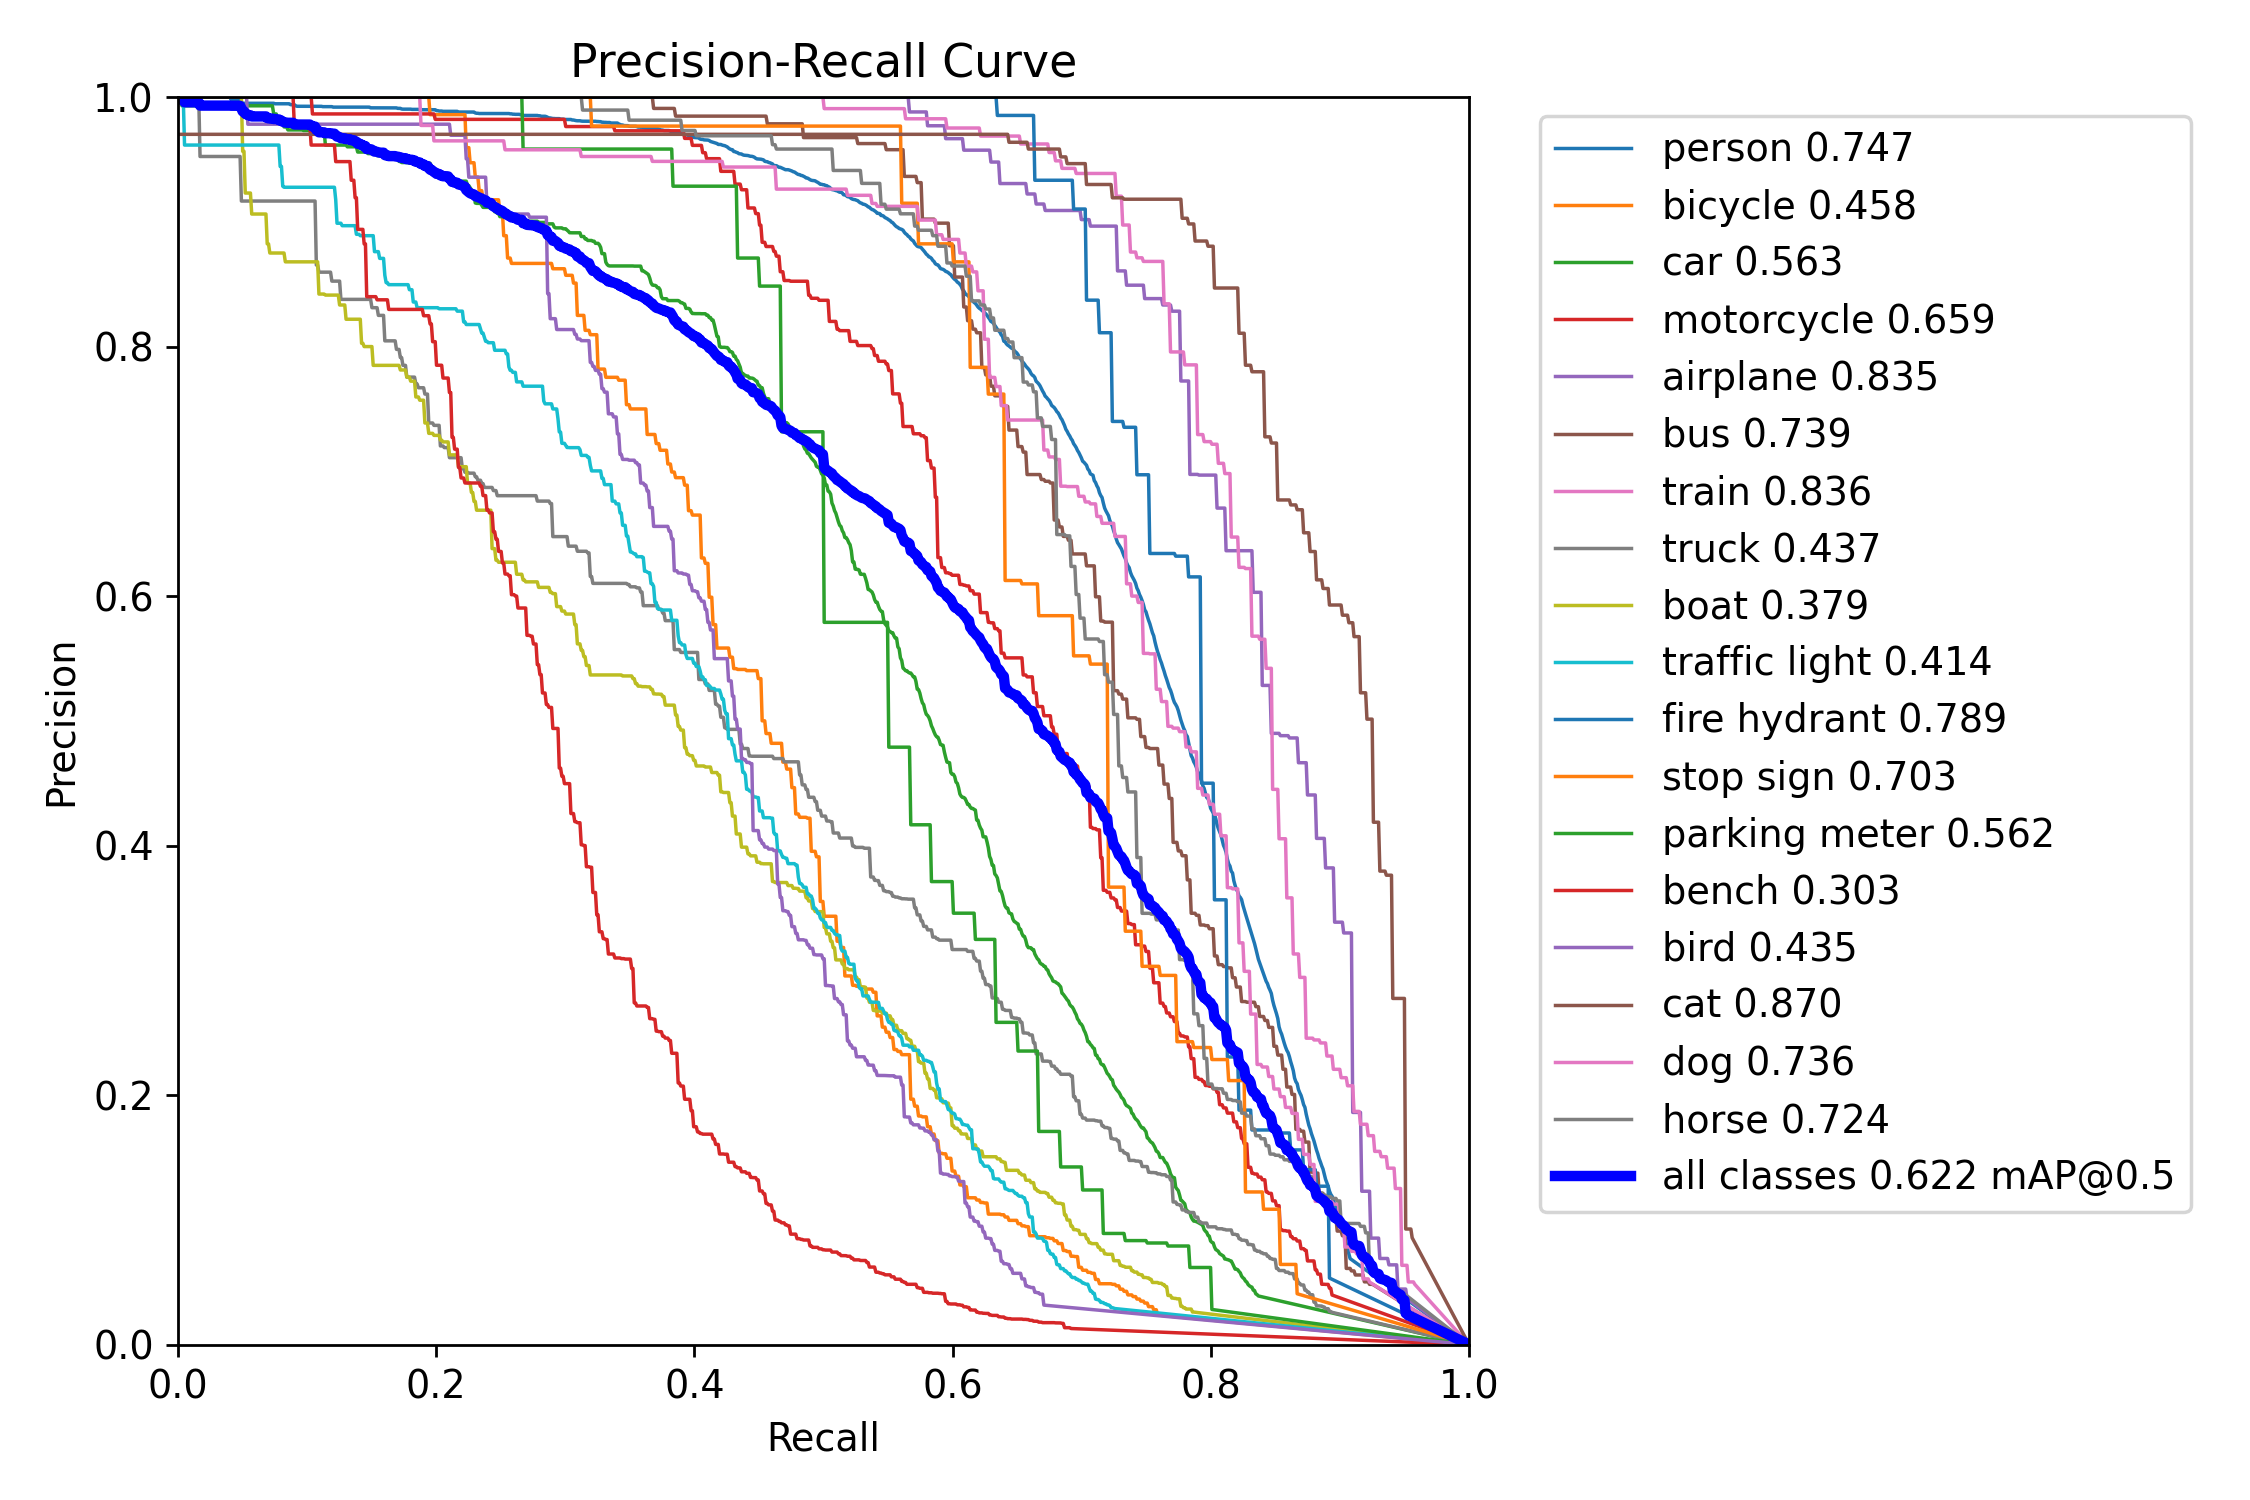

In [14]:
Image(filename='./runs/detect/val/PR_curve.png')

#### 2. Improve on the reference

In [ ]:
model = YOLO('./model/yolov8n.pt')

# Train the model
results = model.train(data='coco.yaml',epochs = 10,device = 'cuda:0',imgsz=640,hsv_s = 0.5, hsv_v = 0.2,degrees = 10, scale = 0.55)

New https://pypi.org/project/ultralytics/8.1.30 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.27 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/best.pt, data=coco.yaml, epochs=4, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False,

train: Scanning /content/dataset/train/labels... 84853 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84853/84853 [04:07<00:00, 343.36it/s]


train: New cache created: /content/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/validation/labels... 3574 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3574/3574 [00:10<00:00, 336.83it/s]

val: New cache created: /content/dataset/validation/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000455, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/4      3.08G      1.314      1.422      1.327         64        640: 100%|██████████| 5304/5304 [39:08<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 112/112 [00:47<00:00,  2.36it/s]


                   all       3574      17230      0.624      0.458      0.499      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/4      2.79G      1.249      1.327       1.28         44        640: 100%|██████████| 5304/5304 [39:03<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 112/112 [00:42<00:00,  2.62it/s]


                   all       3574      17230      0.616      0.472      0.523      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/4      2.59G      1.224       1.28      1.265        141        640:  55%|█████▌    | 2919/5304 [21:39<15:16,  2.60it/s]

In [9]:
# inference
model = YOLO('./runs/detect/train/weights/best.pt')
metrics = model.val(data='coco.yaml',device = 'cuda:0',imgsz=640,hsv_s = 0.5, hsv_v = 0.2,degrees = 10, scale = 0.55)


Ultralytics YOLOv8.1.29 🚀 Python-3.9.12 torch-2.2.1 CPU (Intel Core(TM) i9-9880H 2.30GHz)
Model summary (fused): 168 layers, 3009158 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/daniil.yefimov/Desktop/GitHub/Autonomous-Vehicle/dataset/validation/labels... 3574 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3574/3574 [00:02<00:00, 1784.60it/s]


val: New cache created: /Users/daniil.yefimov/Desktop/GitHub/Autonomous-Vehicle/dataset/validation/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 224/224 [01:33<00:00,  2.40it/s]


                   all       3574      17230      0.531      0.387      0.408      0.279
                person       3574      10777      0.704      0.525      0.597      0.371
               bicycle       3574        314      0.439      0.217      0.199      0.114
                   car       3574       1918      0.531      0.296       0.32      0.181
            motorcycle       3574        367      0.527      0.392      0.439      0.238
              airplane       3574        143      0.586      0.534       0.57       0.41
                   bus       3574        283      0.738      0.488      0.559      0.455
                 train       3574        190      0.688      0.642      0.682      0.511
                 truck       3574        414      0.484      0.191      0.255      0.149
                  boat       3574        424      0.367      0.163      0.159       0.08
         traffic light       3574        634      0.484      0.167      0.174     0.0818
          fire hydran

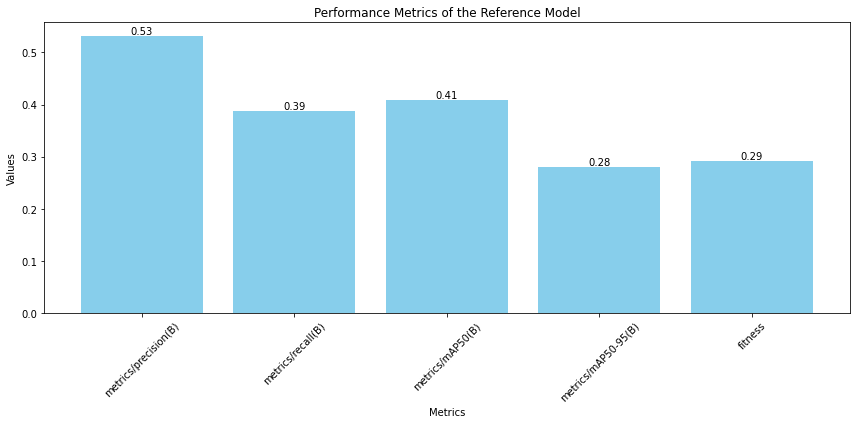

In [12]:
# Extracting metric names and corresponding values
metrics_keys_reference = list(metrics.results_dict.keys())
metrics_values_reference = list(metrics.results_dict.values())

# Creating a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(metrics_keys_reference, metrics_values_reference, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics of the Reference Model')
plt.xticks(rotation=45)
for bar, value in zip(bars, metrics_values_reference):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f'{value:.2f}',
             ha='center',
             va='bottom')
plt.tight_layout()

# Displaying the plot
plt.show()


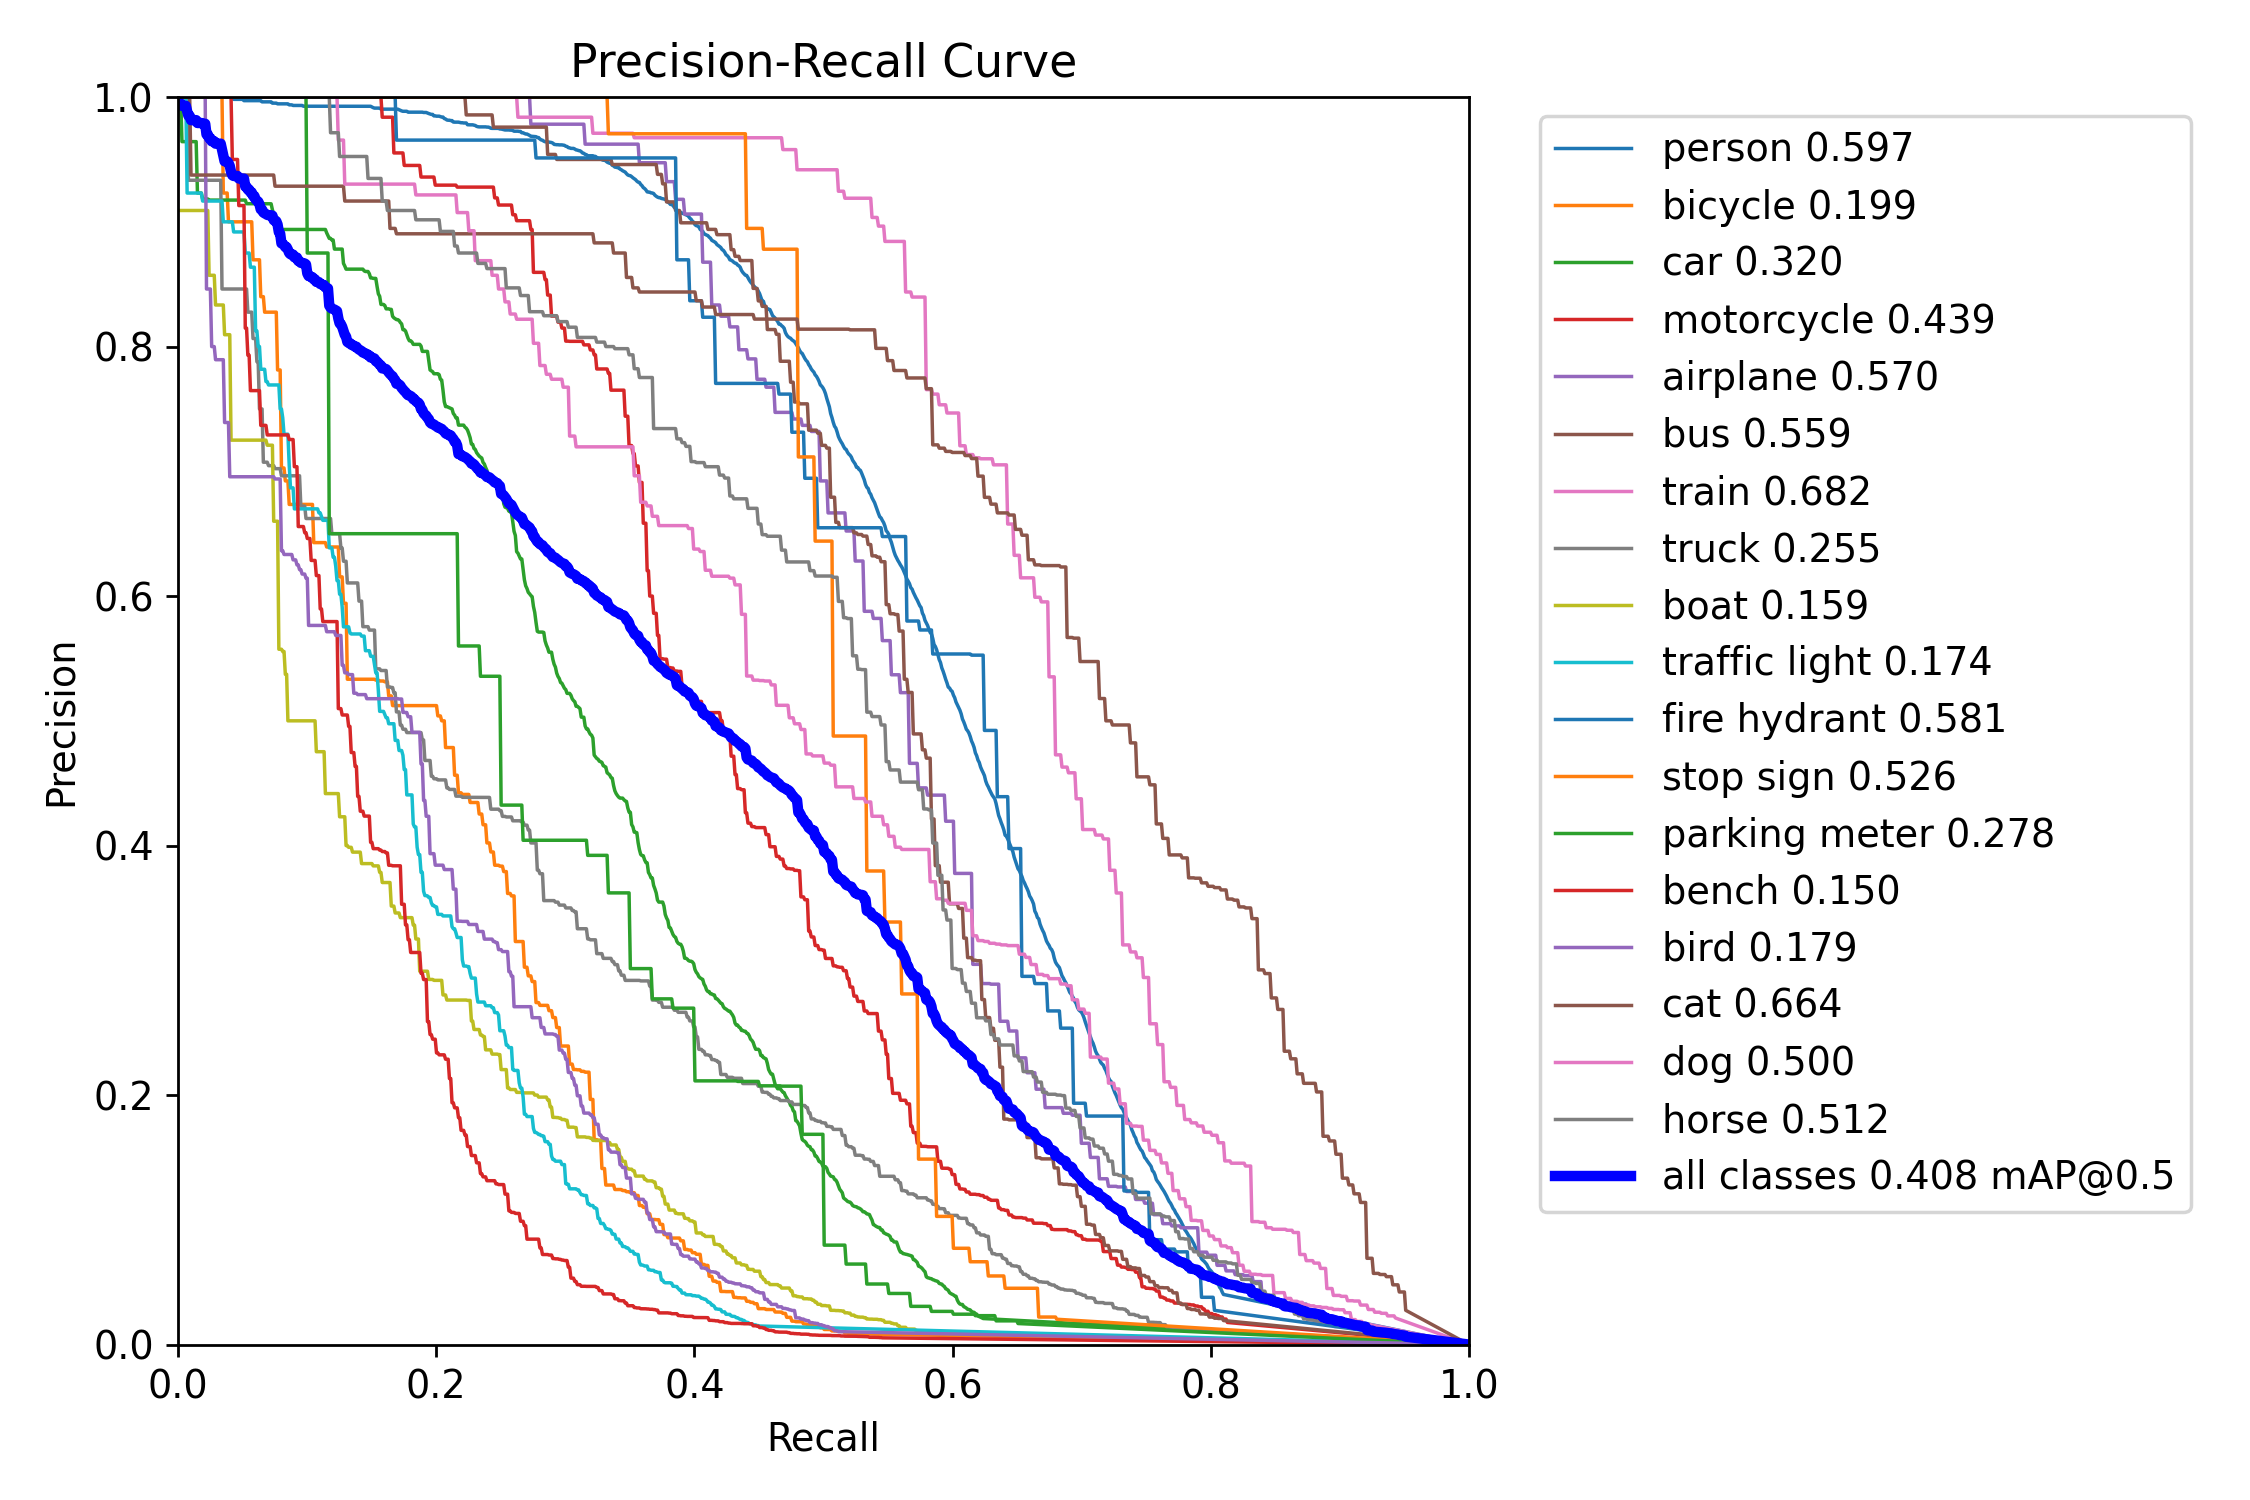

In [15]:
Image(filename='./runs/detect/val2/PR_curve.png')

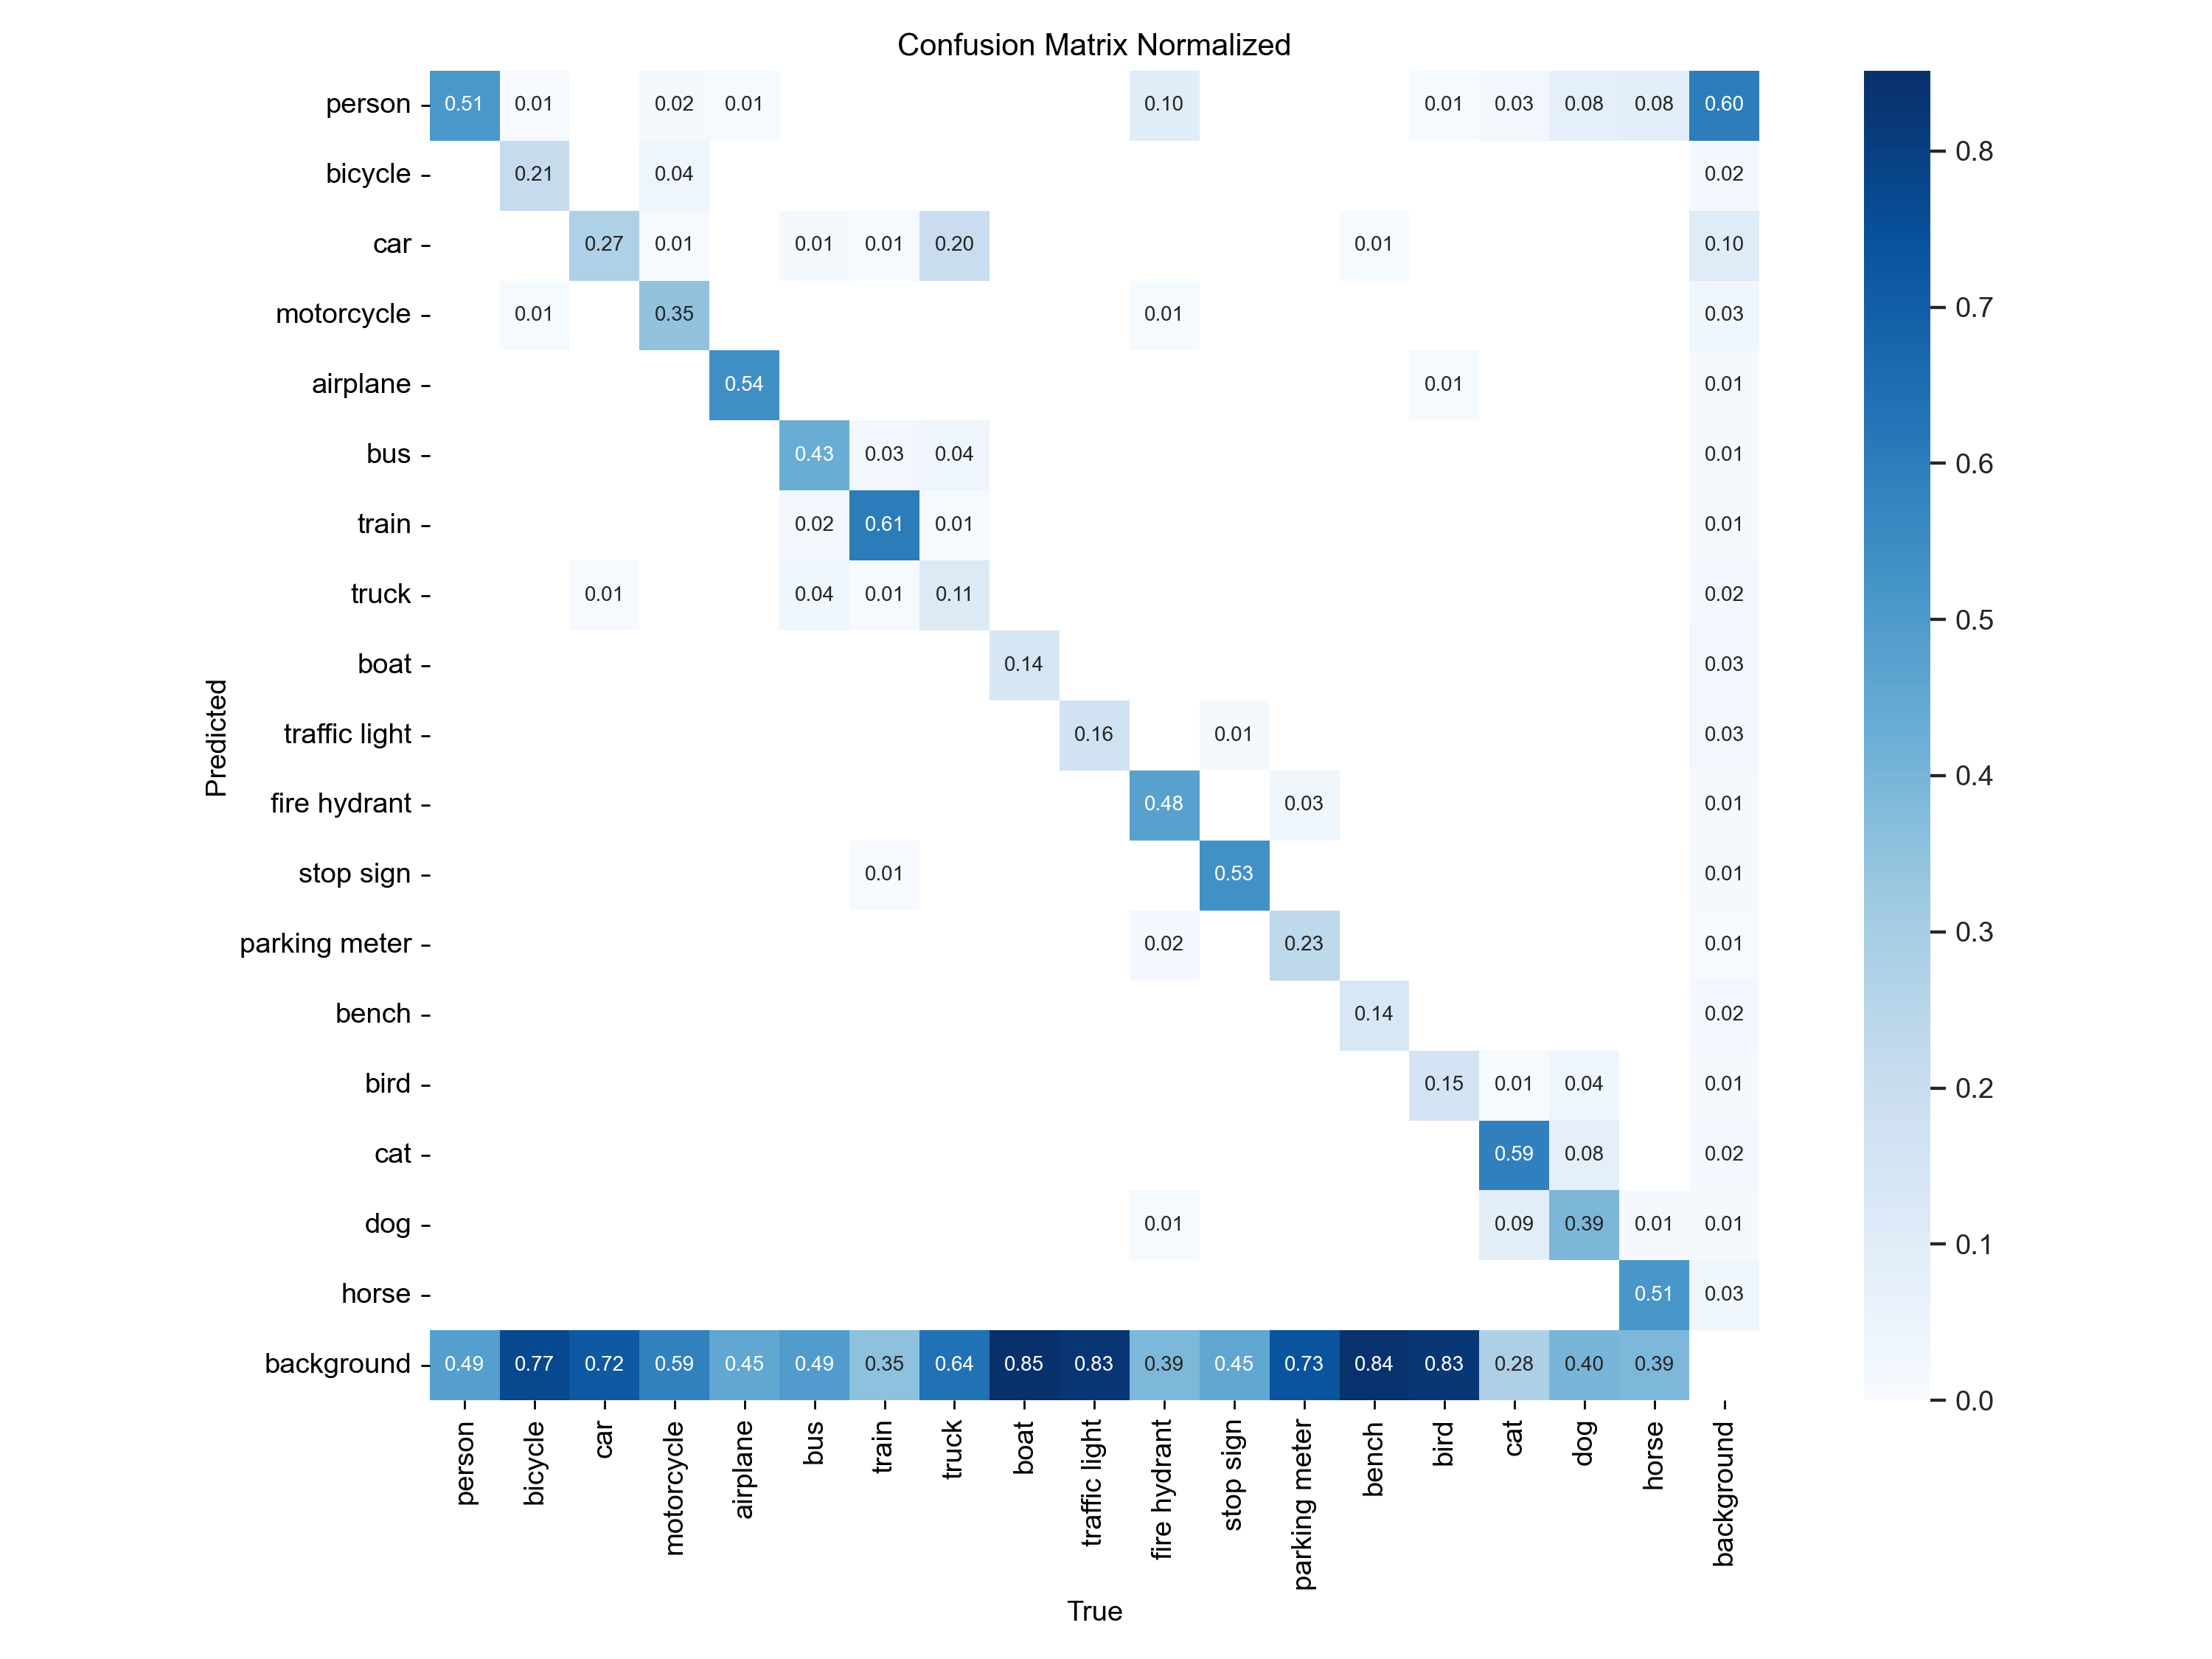

In [16]:
Image(filename='./runs/detect/val2/confusion_matrix_normalized.png')

## Perfomance on the video

In [13]:
# Load the YOLOv8 model
model = YOLO('./runs/detect/train/weights/best.pt')

# Open the video file
video_path = "./road_trafic.mp4"
cap = cv2.VideoCapture(video_path)

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 inference on the frame
        results = model(frame)

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Display the annotated frame
        cv2.imshow("YOLOv8 Inference", annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()


0: 224x352 2 persons, 4 cars, 80.8ms
Speed: 3.2ms preprocess, 80.8ms inference, 1.6ms postprocess per image at shape (1, 3, 224, 352)

0: 224x352 2 persons, 3 cars, 25.3ms
Speed: 15.8ms preprocess, 25.3ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 352)

0: 224x352 2 persons, 3 cars, 76.8ms
Speed: 1.1ms preprocess, 76.8ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 352)

0: 224x352 2 persons, 4 cars, 28.0ms
Speed: 14.6ms preprocess, 28.0ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 352)

0: 224x352 2 persons, 5 cars, 40.9ms
Speed: 1.0ms preprocess, 40.9ms inference, 0.6ms postprocess per image at shape (1, 3, 224, 352)

0: 224x352 2 persons, 4 cars, 50.5ms
Speed: 7.1ms preprocess, 50.5ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 352)

0: 224x352 3 persons, 7 cars, 49.5ms
Speed: 1.2ms preprocess, 49.5ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 352)

0: 224x352 2 persons, 6 cars, 21.4ms
Speed: 9.4ms pr

: 